# Exploritary Data Analysis for the jobs dataset
only the jobs which match to some candidates

## Import libraries

In [1]:
import re
import json
import pymorphy3
import tokenize_uk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Load data

In [2]:
df = pd.read_csv('../../data/prepared_jobs/jobs_prepared.csv')
df.head()

,Position,Long Description,Company Name,Exp Years,Primary Keyword,English Level,Published,Long Description_lang,id
0,1c developer,Компанія співпрацює з такими лідерами фарма і...,AboutHR,2y,Other,NaN,2021-06-01T00:00:00+03:00,uk,0e8d1ddb-b002-53c2-a761-20406026f153
1,1C developer,"IT компанія “Нова Пошта Діджитал”, що входить ...",Nova Poshta Digital,3y,Other,NaN,2023-03-01T00:00:00+02:00,uk,3f65951b-c5c3-5472-a39b-6bbf516addc1
2,1C developer,Вимоги до успішного кандидата:\r\n— Програміст...,Zakaz.ua,3y,Other,NaN,2022-02-01T00:00:00+02:00,uk,741d9555-9324-54ca-af5b-de4887b0f978
3,1C developer,ОККО запрошує стати частиною потужної команди ...,OKKO Group,3y,Other,NaN,2021-07-01T00:00:00+03:00,uk,5002f118-575e-5325-83c5-8075e5554bdf
4,1C Developer,**Everad** — міжнародна CPA-мережа з прямим ре...,Everad,3y,Other,NaN,2023-04-01T00:00:00+03:00,uk,70a9a45b-302f-59a5-a4e1-ee0da427a5f1


In [3]:
unique_jobs = list(json.load(open('../../data/final_groups/groups.json')).values())
unique_jobs =list(set([job for jobs in unique_jobs for job in jobs]))
print("Unique jobs count:",len(unique_jobs))

Unique jobs count: 60940


In [4]:
df = df[df['id'].isin(unique_jobs)].reset_index(drop=True)
print("Jobs count after filtering:",len(df['id'].unique()))
df.head()

Jobs count after filtering: 60940


,Position,Long Description,Company Name,Exp Years,Primary Keyword,English Level,Published,Long Description_lang,id
0,2d artist,"Ти - талановитий 2d artist Generalist, який не...",KAVA Gaming,3y,Artist,NaN,2023-07-01T00:00:00+03:00,uk,cb258024-29b6-5824-9931-32688291447c
1,2d Artist,Boolat Games – це студія розробки мультиплатфо...,Boolat Games,3y,Artist,NaN,2023-07-01T00:00:00+03:00,uk,845f347a-259d-5a4d-b507-11a914740801
2,2d Artist,Вимоги:\r\nДосвід роботи в ігровій індустрії н...,Briteam,2y,Artist,NaN,2022-01-01T00:00:00+02:00,uk,df02e3be-1e32-5c84-bf7a-03d4ae681482
3,2d Artist,"У компанію, що займається гіперказуальними ігр...",Alta Games,1y,Artist,NaN,2023-09-01T00:00:00+03:00,uk,d80e5e14-d633-5f42-9734-372467507932
4,2D artist,"**«BG Games»** — українська **ІТ**-компанія, я...",BG-Games,no_exp,Artist,NaN,2023-08-01T00:00:00+03:00,uk,1dfe1587-c39f-5881-9f86-62c0d0df1de8


## General dataset statistics

In [5]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60940 entries, 0 to 60939
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Position               60940 non-null  object
 1   Long Description       60940 non-null  object
 2   Company Name           60940 non-null  object
 3   Exp Years              60940 non-null  object
 4   Primary Keyword        60940 non-null  object
 5   English Level          57198 non-null  object
 6   Published              60940 non-null  object
 7   Long Description_lang  60940 non-null  object
 8   id                     60940 non-null  object
dtypes: object(9)
memory usage: 4.2+ MB


In [6]:
# unique values counts for each column
for col in df.columns:
    print(col,'\t', len(df[col].unique()))

Position 	 4141
Long Description 	 60940
Company Name 	 7877
Exp Years 	 5
Primary Keyword 	 41
English Level 	 6
Published 	 45
Long Description_lang 	 2
id 	 60940


In [7]:
# general statistics
df.describe()

,Position,Long Description,Company Name,Exp Years,Primary Keyword,English Level,Published,Long Description_lang,id
count,60940,60940,60940,60940,60940,57198,60940,60940,60940
unique,4141,60940,7877,5,41,5,45,2,60940
top,DevOps Engineer,"Ти - талановитий 2d artist Generalist, який не...",GlobalLogic,3y,JavaScript,upper,2022-01-01T00:00:00+02:00,en,cb258024-29b6-5824-9931-32688291447c
freq,1584,1,1406,21193,7025,27917,2459,60022,1


## Additional function

In [8]:
def hist_with_stat_line(df, col, title):
    df[col].str.len().plot(kind= 'hist',bins=100, figsize=(15,5), color='green', alpha=0.5, title=title)
    plt.axvline(df[col].str.len().median(), color='red', linestyle='dashed', linewidth=1, label='median')
    plt.axvline(df[col].str.len().quantile(0.25), color='black', linestyle='dashed', linewidth=1, label='25%')
    plt.axvline(df[col].str.len().quantile(0.75), color='black', linestyle='dashed', linewidth=1, label='75%')
    plt.axvline(df[col].str.len().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean')
    plt.legend()
    plt.show()

## Statistics and plots for each column

### Position column
`manual written position titles`

In [9]:
# min, max, mean, median, 25%, 50%, 75% for length of Position column
df['Position'].str.len().describe()

count    60940.000000
mean        19.092173
std          5.820447
min          2.000000
25%         15.000000
50%         19.000000
75%         23.000000
max         49.000000
Name: Position, dtype: float64

<Axes: title={'center': 'Top 20 most popular positions'}, xlabel='Position'>

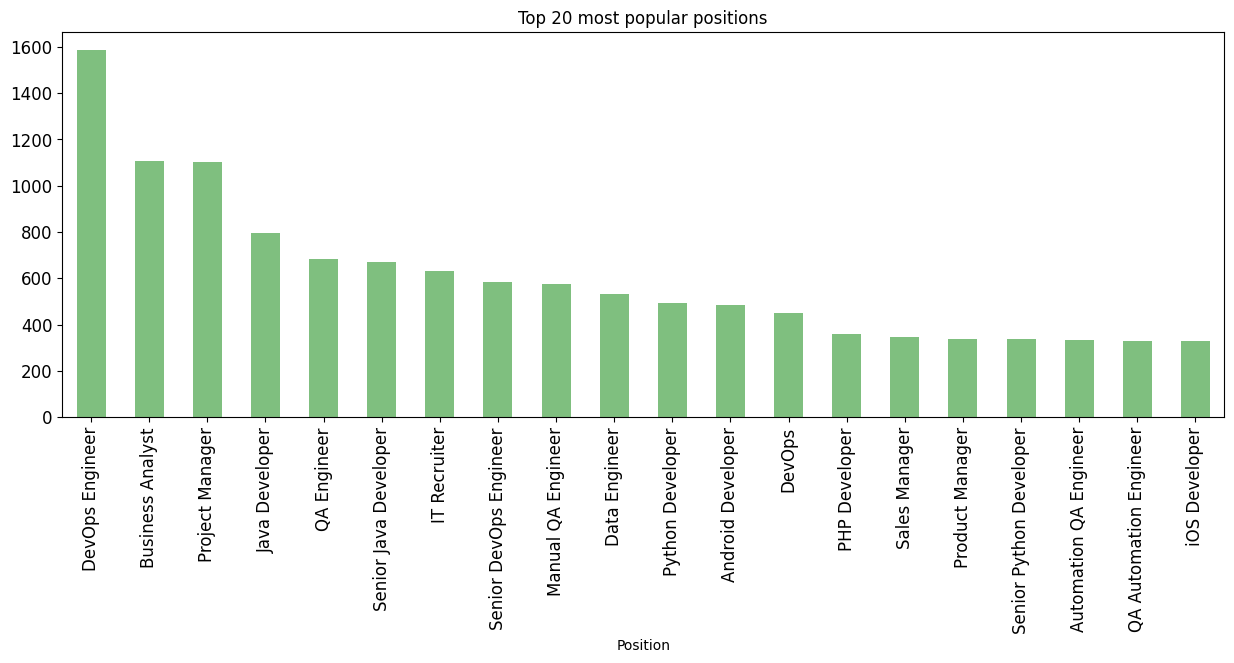

In [10]:
# top 20 most popular positions as a bar chart
df['Position'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular positions', 
                                        fontsize=12, color='green', alpha=0.5)


In [11]:
# tail 20 positions
df['Position'].value_counts()[-20:]

Position
Game tester (QA)                   1
QA  Automation Engineer            1
General QA Engineer (Java)         1
Global IT Recruiter                1
Global Marketing Manager           1
Global PR Manager                  1
QA/AQA Engineer                    1
Goland Developer                   1
Golang backend developer           1
Python Test Automation Engineer    1
Golang Backend Developer           1
Python QA automation engineer      1
Python QA Automation               1
Python/Odoo Developer              1
Python Odoo Developer              1
Python/JavaScript Developer        1
Python/Golang Developer            1
Golang engineer                    1
Python/Flask Developer             1
Таргетолог                         1
Name: count, dtype: int64

we can see that the most common position and some of the rarest positions can be really similar due to manual writing of the position titles.

<Axes: title={'center': 'Top 20 most popular positions. English language'}, xlabel='Position'>

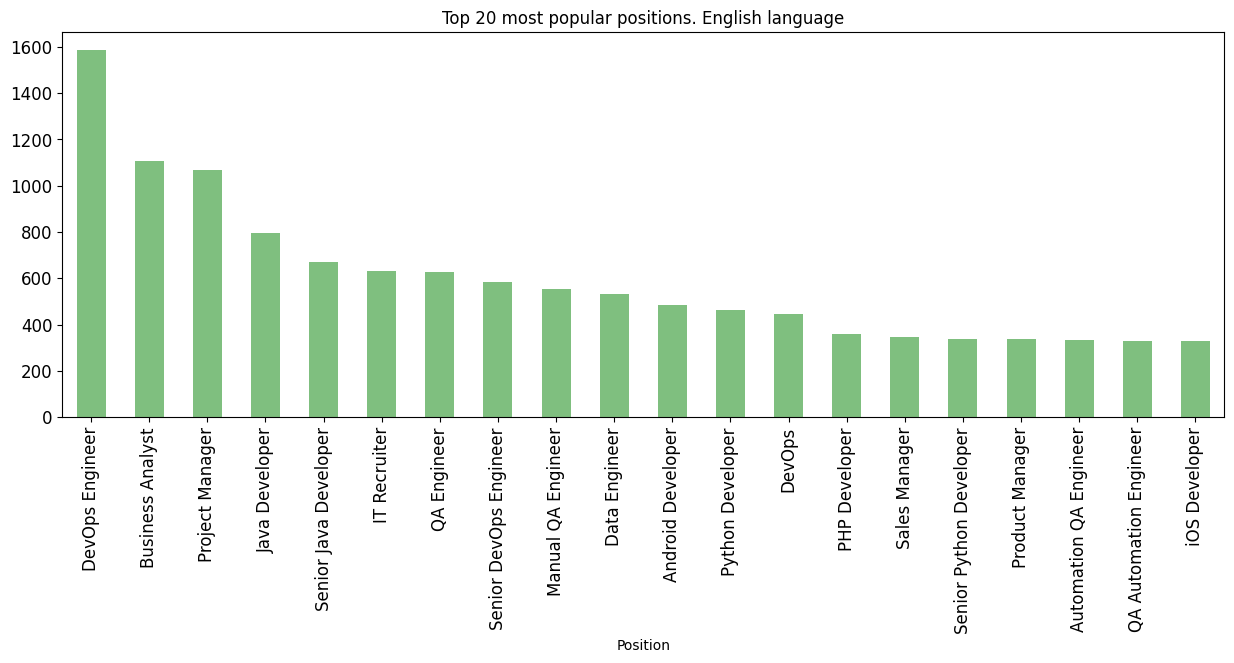

In [12]:
# top 20 most popular positions as a bar chart and show count of each position. English version
df[df['Long Description_lang']=='en']['Position'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular positions. English language', 
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular positions. Ukrainian language'}, xlabel='Position'>

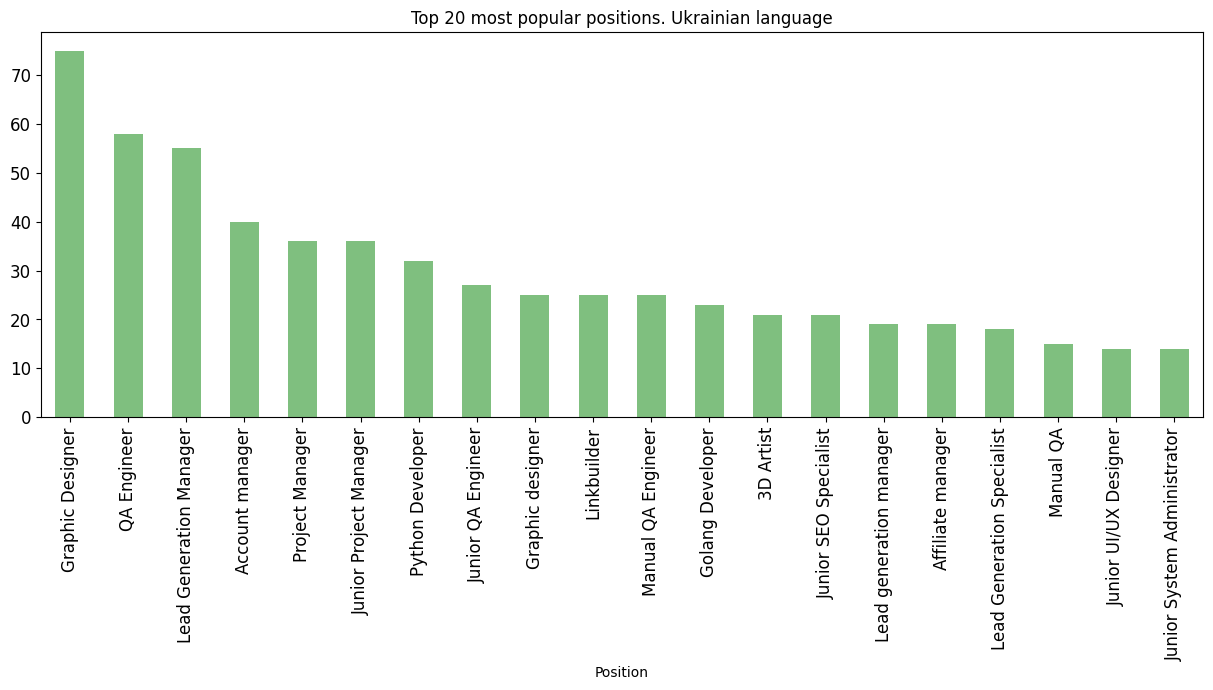

In [13]:
# top 20 most popular positions as a bar chart and show count of each position. English version
df[df['Long Description_lang']=='uk']['Position'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular positions. Ukrainian language', 
                                        fontsize=12, color='green', alpha=0.5)

### Long Description column
`manual written job description`

In [14]:
# Long Description column length statistics
df['Long Description'].str.len().describe()

count    60940.000000
mean      1733.631884
std        912.738441
min         80.000000
25%       1087.000000
50%       1577.000000
75%       2190.000000
max       9533.000000
Name: Long Description, dtype: float64

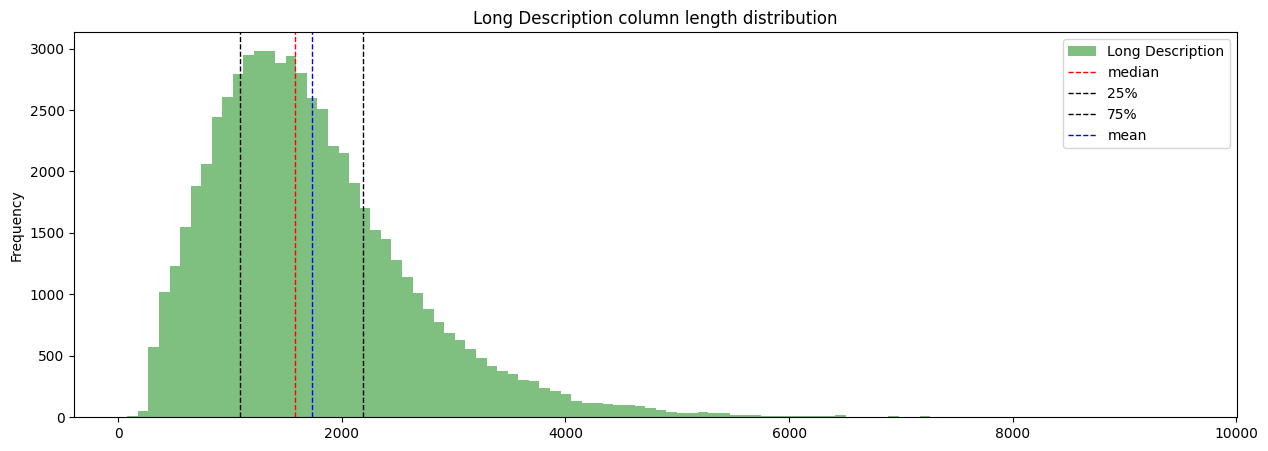

In [15]:
# distribution of Long Description column length
hist_with_stat_line(df, 'Long Description', 'Long Description column length distribution')

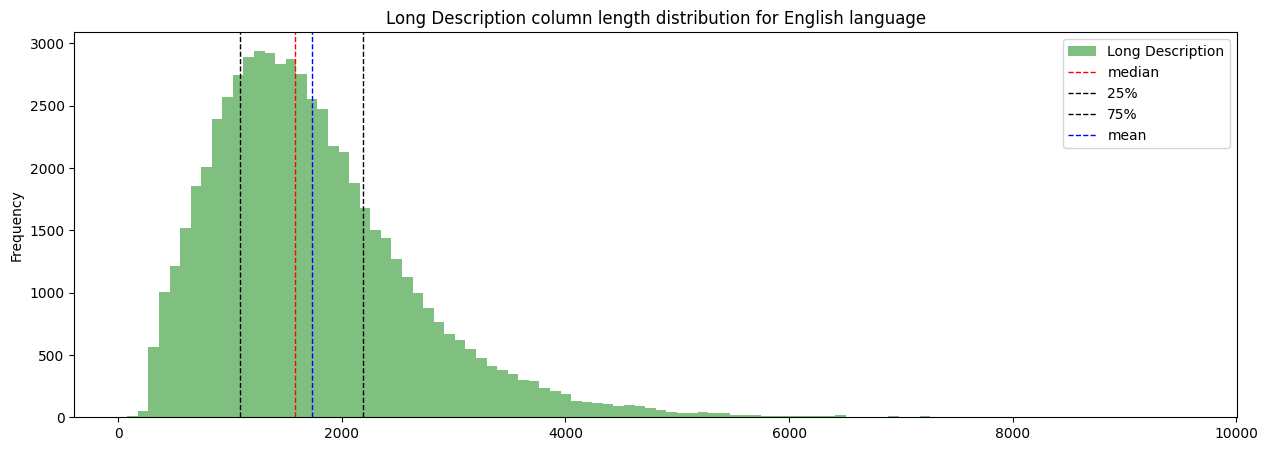

In [16]:
# distribution of Long Description column length for English language
hist_with_stat_line(df[df['Long Description_lang']=='en'], 'Long Description', 'Long Description column length distribution for English language')

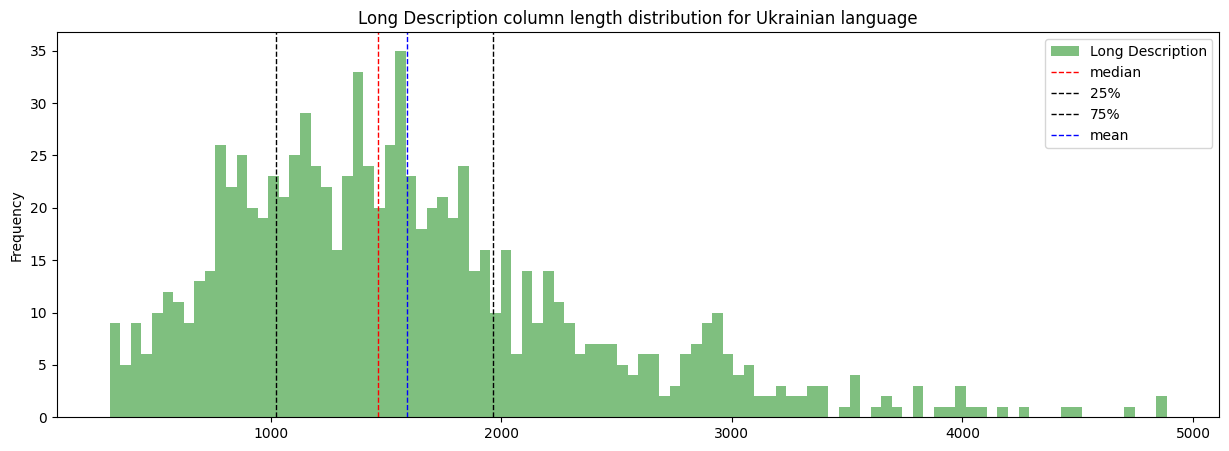

In [17]:
# distribution of Long Description column length for Ukrainian language
hist_with_stat_line(df[df['Long Description_lang']=='uk'], 'Long Description', 'Long Description column length distribution for Ukrainian language')

### Company Name
`company name which hires`

In [18]:
# min, max, mean, median, 25%, 50%, 75% for length of Company Name column
df['Company Name'].str.len().describe()

count    60940.000000
mean        10.252773
std          4.963878
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         72.000000
Name: Company Name, dtype: float64

<Axes: title={'center': 'Top 20 companies that hire the most'}, xlabel='Company Name'>

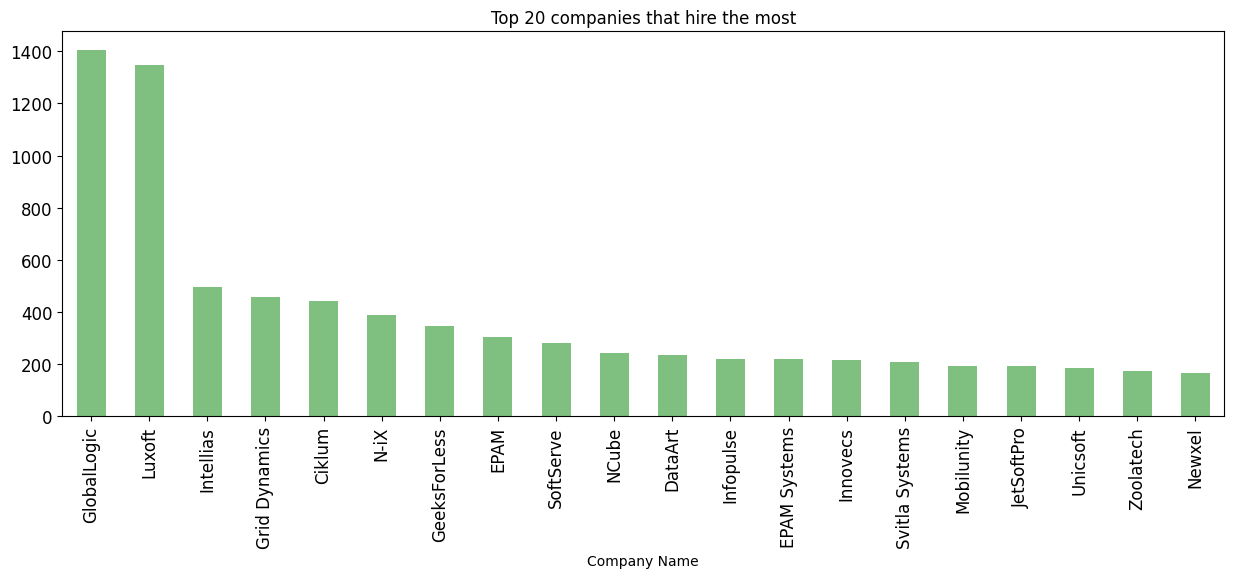

In [19]:
# top 20 most companies that hire the most as a bar chart
df['Company Name'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 companies that hire the most', 
                                        fontsize=12, color='green', alpha=0.5)

In [20]:
# tail 20 companies that hire
df['Company Name'].value_counts()[-20:]

Company Name
Sales'Up                            1
Kuna.io                             1
Techiia IT Holding                  1
demch.co                            1
Flatstudio                          1
Польський Бізнес-Центр              1
hypra.fund                          1
Mobilife+                           1
MirageTech                          1
H&J International Technology LLc    1
Consimple                           1
Stormotion                          1
Catalisto                           1
Jobchain GmbH                       1
SavvyService                        1
Jellyworkz                          1
CROSSVERSE                          1
Flr Finance                         1
Robosoft                            1
HERZ Ukraine                        1
Name: count, dtype: int64

<Axes: xlabel='Published_year', ylabel='Company Name'>

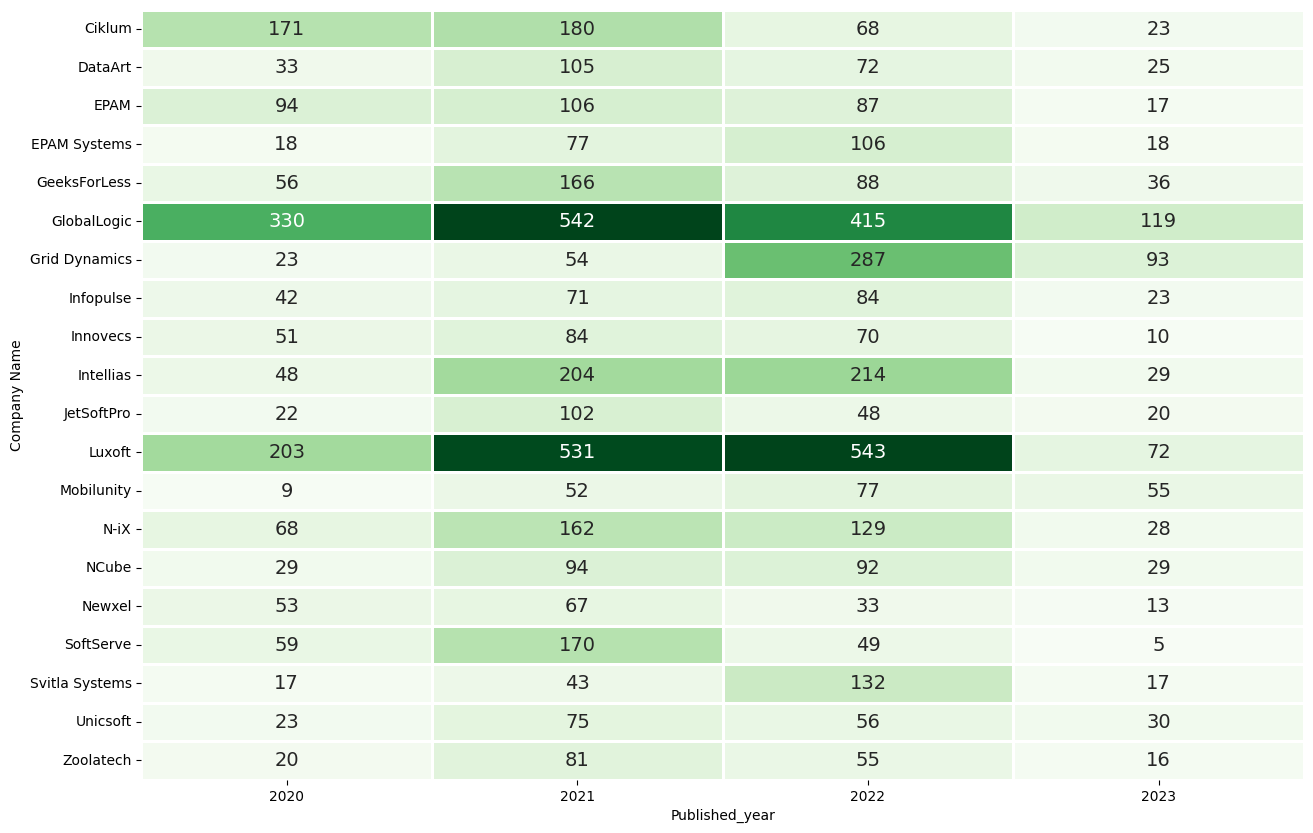

In [21]:
# number of vacancies for top 20 companices per year (Published(str) need to extract year) as headmap
df['Published_year'] = df['Published'].apply(lambda x: int(re.findall(r'\d{4}', x)[0]))

plt.figure(figsize=(15,10))
sns.heatmap(df[df['Company Name'].isin(df['Company Name'].value_counts()[:20].index)].pivot_table(index='Company Name', columns='Published_year', values='id', aggfunc='count'), 
            cmap='Greens', annot=True, fmt='.0f', linewidths=.8, cbar=False, annot_kws={"size": 14})

<Axes: title={'center': 'Top 20 most popular companies. English language'}, xlabel='Company Name'>

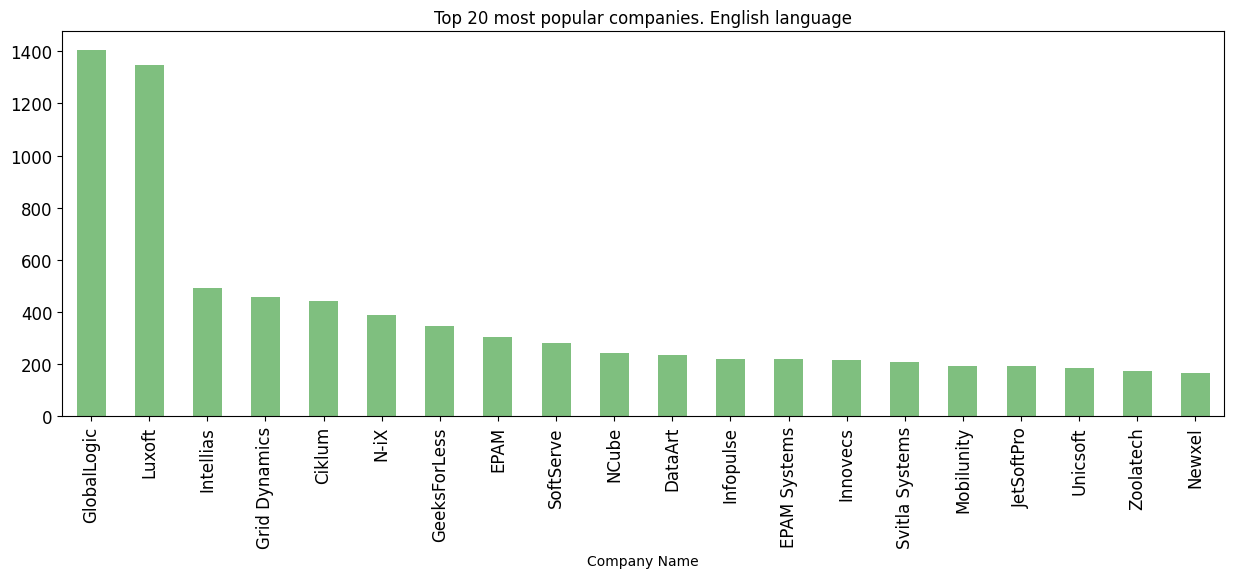

In [22]:
# top 20 most popular companies as a bar chart and show count of each company. English version
df[df['Long Description_lang']=='en']['Company Name'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular companies. English language', 
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular companies. Ukrainian language'}, xlabel='Company Name'>

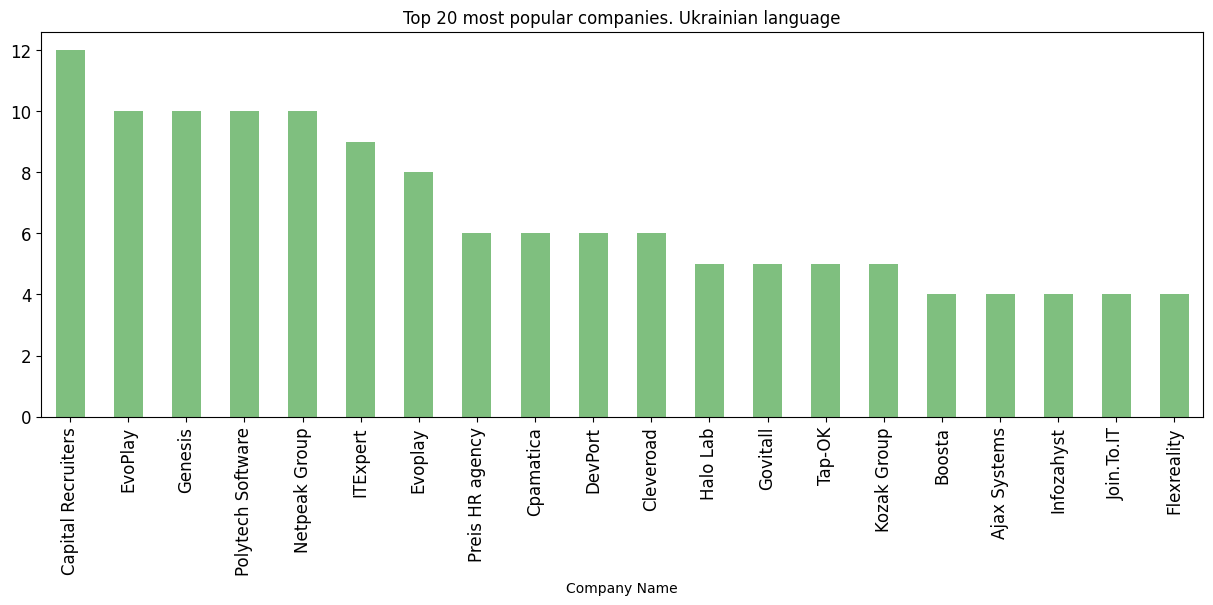

In [23]:
# top 20 most popular companies as a bar chart and show count of each company. Ukrainian version
df[df['Long Description_lang']=='uk']['Company Name'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular companies. Ukrainian language', 
                                        fontsize=12, color='green', alpha=0.5)

Text(0.5, 1.0, 'Top 10 companies to top 10 positions')

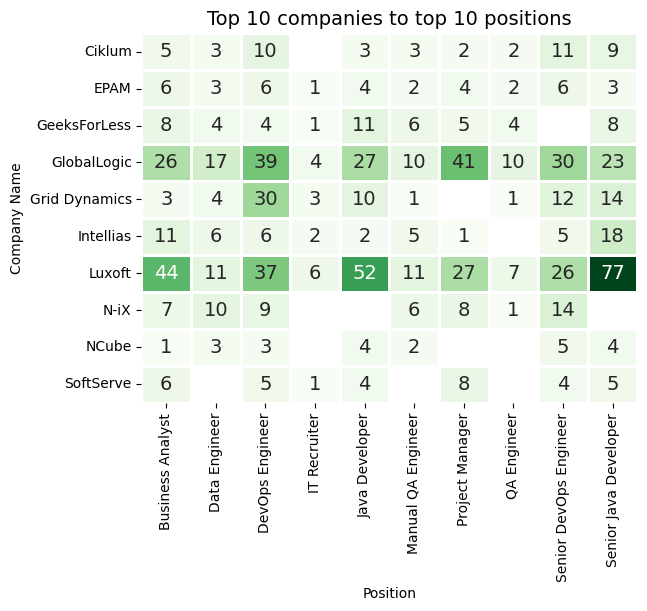

In [24]:
# top 10 companies to top 10 positions as matrix
sns.heatmap(df[df['Company Name'].isin(df['Company Name'].value_counts()[:10].index) & df['Position'].isin(df['Position'].value_counts()[:10].index)].pivot_table(index='Company Name', columns='Position', values='id', aggfunc='count'),
            cmap='Greens', annot=True, fmt='.0f', linewidths=.8, cbar=False, annot_kws={"size": 14})
plt.title('Top 10 companies to top 10 positions', fontsize=14)

### Exp Years
`experience years required`

In [25]:
df['Exp Years'].unique()

array(['3y', '2y', '1y', 'no_exp', '5y'], dtype=object)

In [26]:
# transform Exp Years column to numeric
map_exp =  {
    "3y": 3,
    "1y": 1,
    "2y": 2,
    "5y": 5,
    "no_exp": 0,
}
df['Exp Years'] = df['Exp Years'].map(map_exp)

In [27]:
# general statistics for Experience Years column
df['Exp Years'].describe()

count    60940.000000
mean         2.536413
std          1.349495
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: Exp Years, dtype: float64

<Axes: title={'center': 'Experience Years count'}, xlabel='Exp Years'>

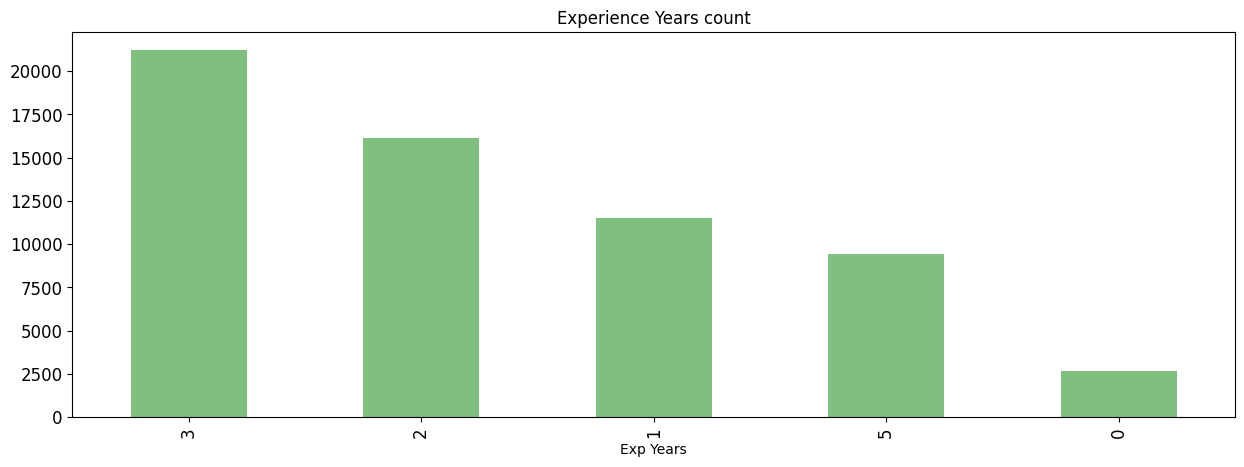

In [28]:
# bar chart for Experience Years column
df['Exp Years'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Experience Years count',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Experience Years count. English language'}, xlabel='Exp Years'>

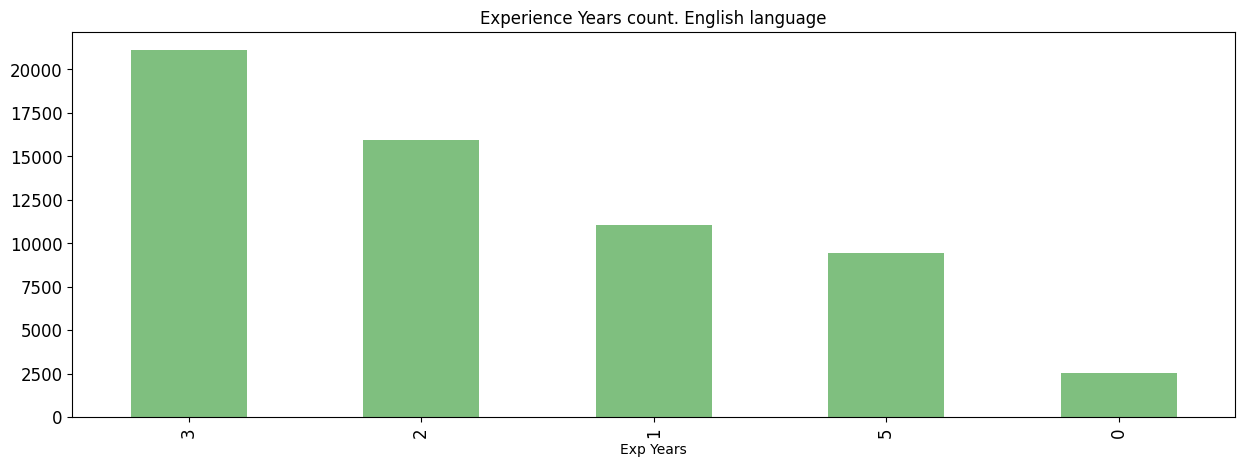

In [29]:
# bar chart for Experience Years column for English language
df[df['Long Description_lang']=='en']['Exp Years'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Experience Years count. English language',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Experience Years count. Ukrainian language'}, xlabel='Exp Years'>

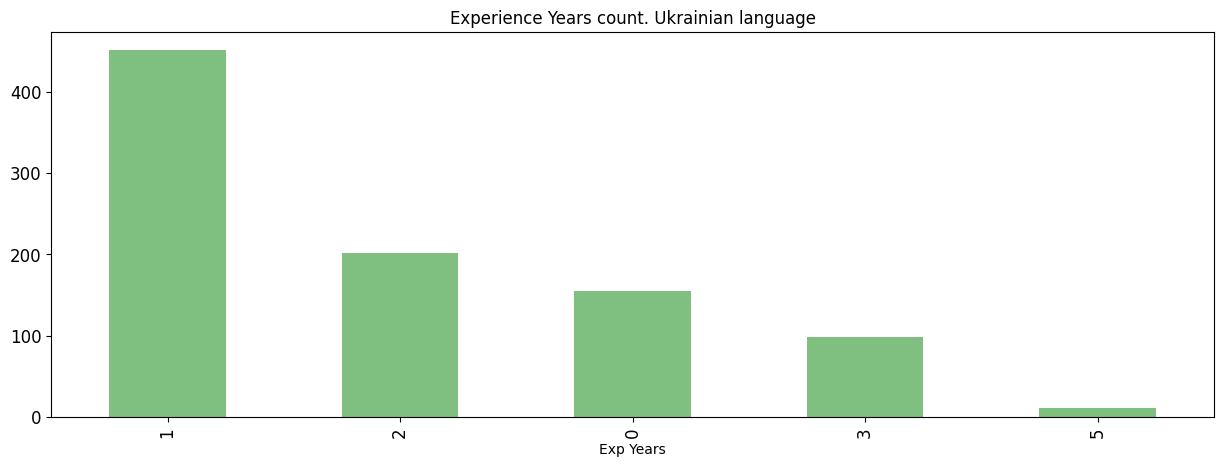

In [30]:
# bar chart for Experience Years column for Ukrainian language
df[df['Long Description_lang']=='uk']['Exp Years'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Experience Years count. Ukrainian language',
                                            fontsize=12, color='green', alpha=0.5)

### Primary Keyword
`job profile type`

In [31]:
# unique Primary Keyword count
print("Unique Primary Keyword count:",len(df['Primary Keyword'].unique()))

Unique Primary Keyword count: 41


<Axes: title={'center': 'Top 20 most popular Primary Keywords'}, xlabel='Primary Keyword'>

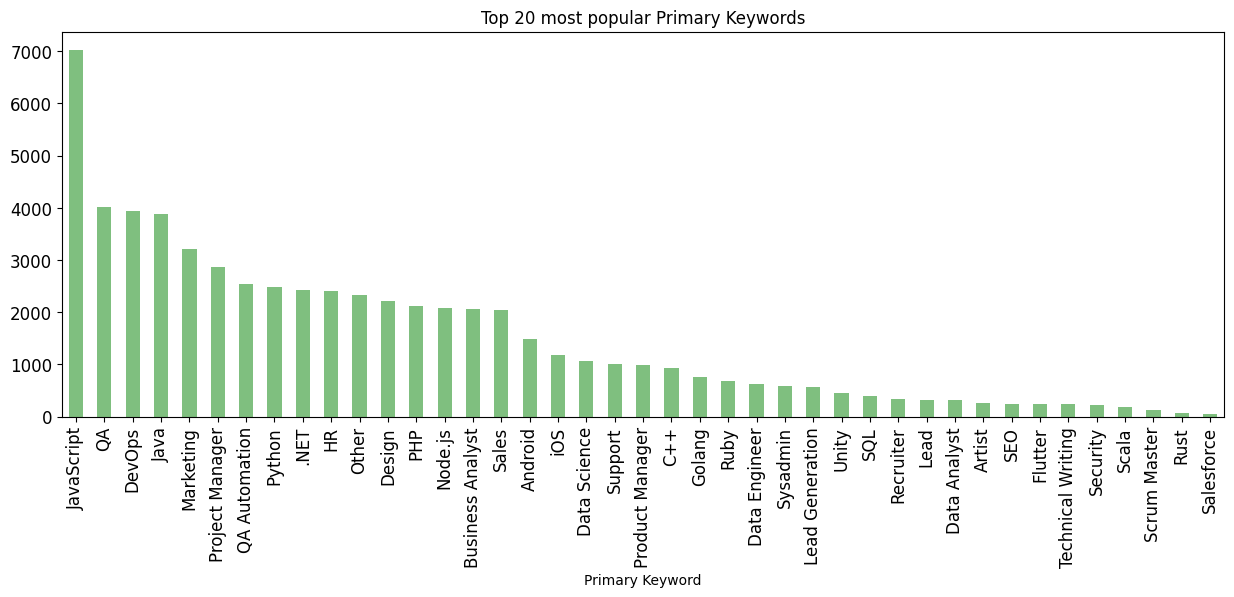

In [32]:
# primary keyword bar chart
df['Primary Keyword'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Top 20 most popular Primary Keywords',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular Primary Keywords. English language'}, xlabel='Primary Keyword'>

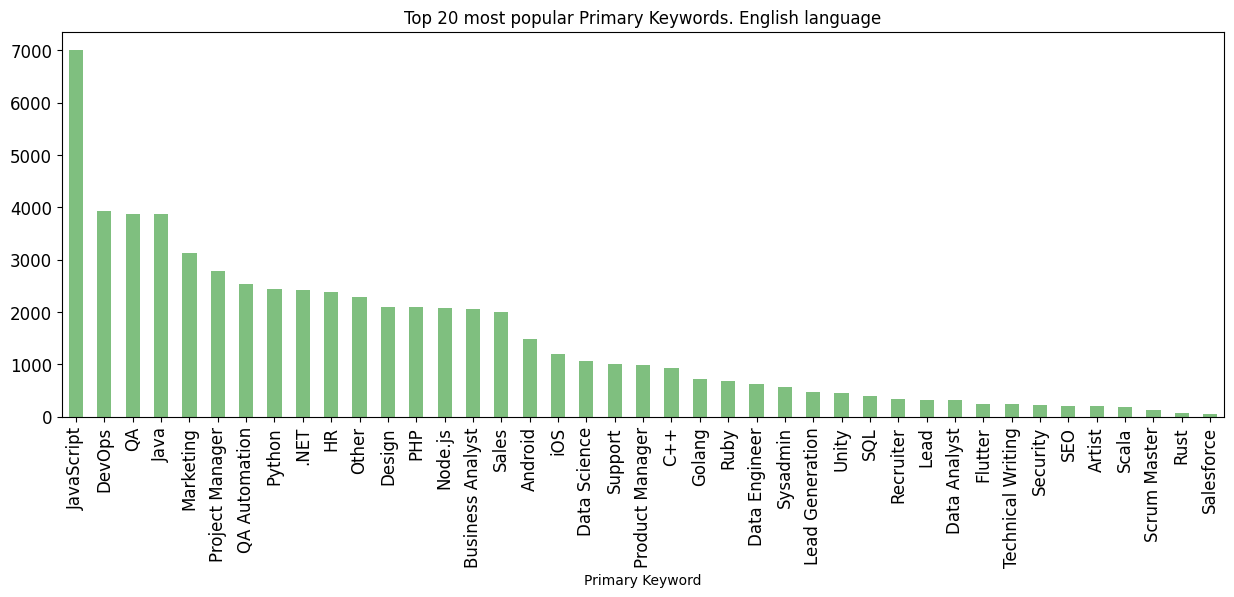

In [33]:
# primary keyword bar chart for English language
df[df['Long Description_lang']=='en']['Primary Keyword'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Top 20 most popular Primary Keywords. English language',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular Primary Keywords. Ukrainian language'}, xlabel='Primary Keyword'>

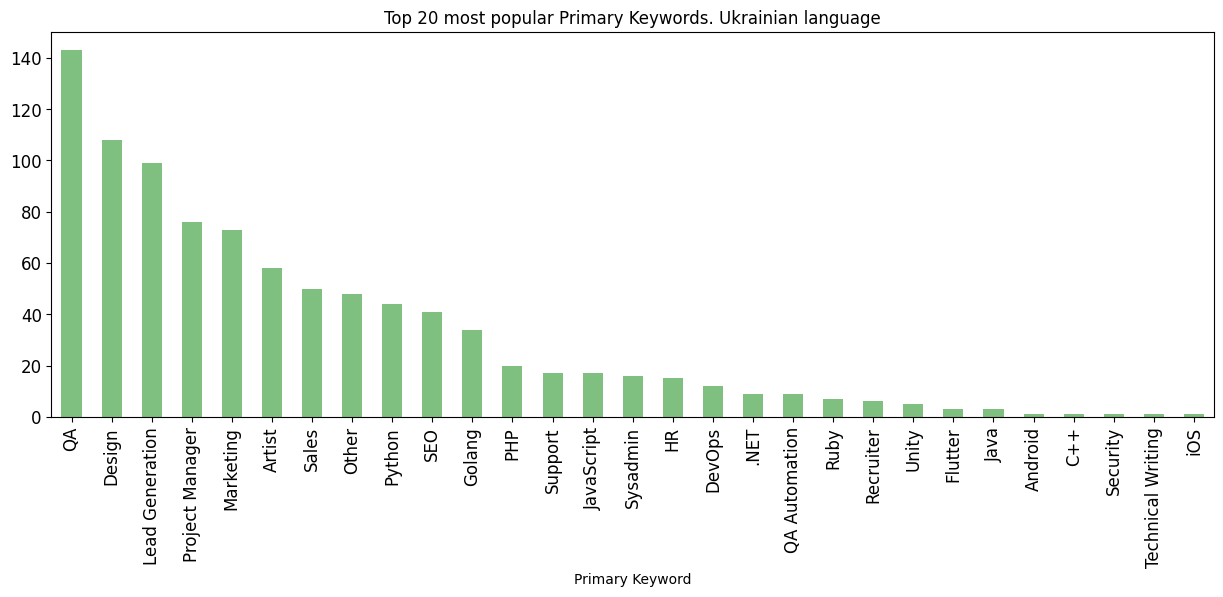

In [34]:
# primary keyword bar chart for Ukrainian language
df[df['Long Description_lang']=='uk']['Primary Keyword'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Top 20 most popular Primary Keywords. Ukrainian language',
                                            fontsize=12, color='green', alpha=0.5)

Text(0.5, 1.0, 'Top 10 companies to top 10 Primary Keyword')

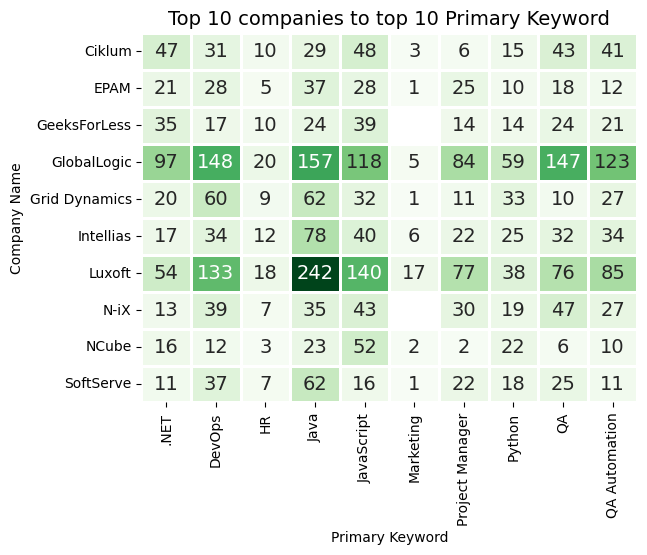

In [35]:
# top 10 companies to top 10 Primary Keyword as matrix
sns.heatmap(df[df['Company Name'].isin(df['Company Name'].value_counts()[:10].index) & df['Primary Keyword'].isin(df['Primary Keyword'].value_counts()[:10].index)].pivot_table(index='Company Name', 
                                                                                                                                                                                columns='Primary Keyword', values='id', aggfunc='count'),
            cmap='Greens', annot=True, fmt='.0f', linewidths=.8, cbar=False, annot_kws={"size": 14})
plt.title('Top 10 companies to top 10 Primary Keyword', fontsize=14)

# English Level
`english level required`

In [36]:
# unique English Level count
print("Unique English Level count:",len(df['English Level'].unique()))

Unique English Level count: 6


<Axes: title={'center': 'English Level count'}, xlabel='English Level'>

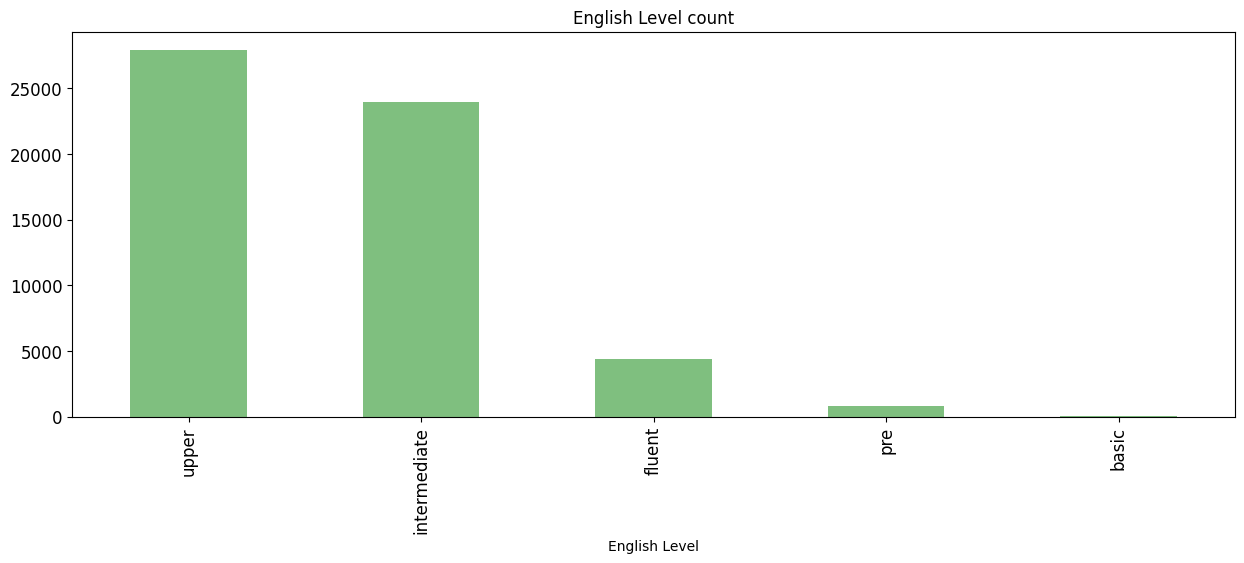

In [37]:
# English Level bar chart
df['English Level'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='English Level count',
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'English Level count. English language'}, xlabel='English Level'>

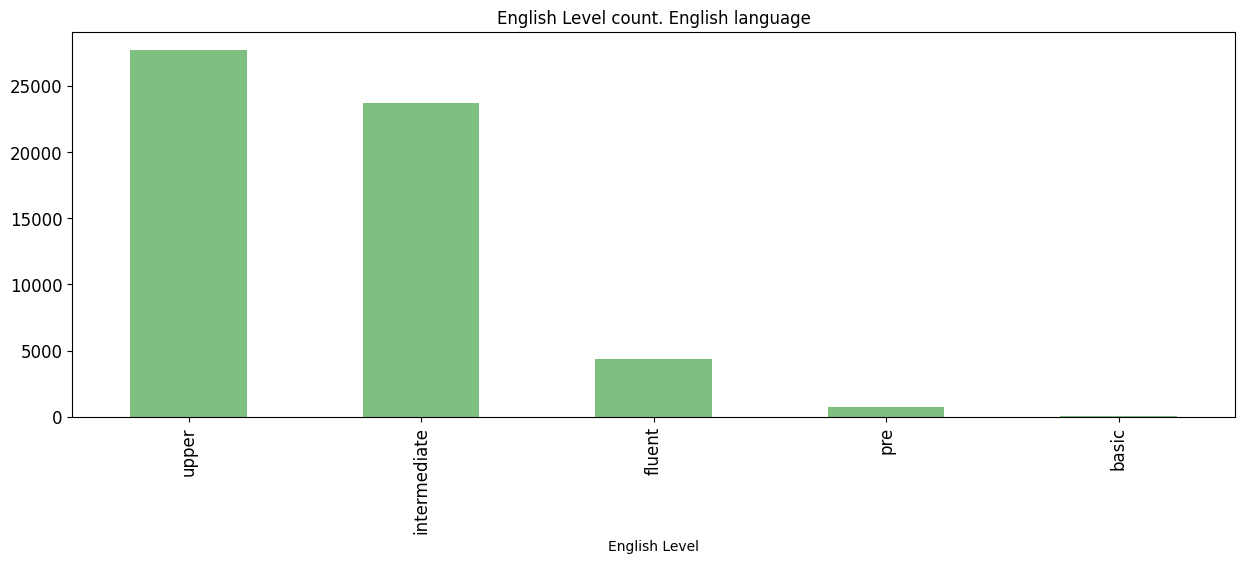

In [38]:
# English Level bar chart for English language
df[df['Long Description_lang']=='en']['English Level'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='English Level count. English language',
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'English Level count. Ukrainian language'}, xlabel='English Level'>

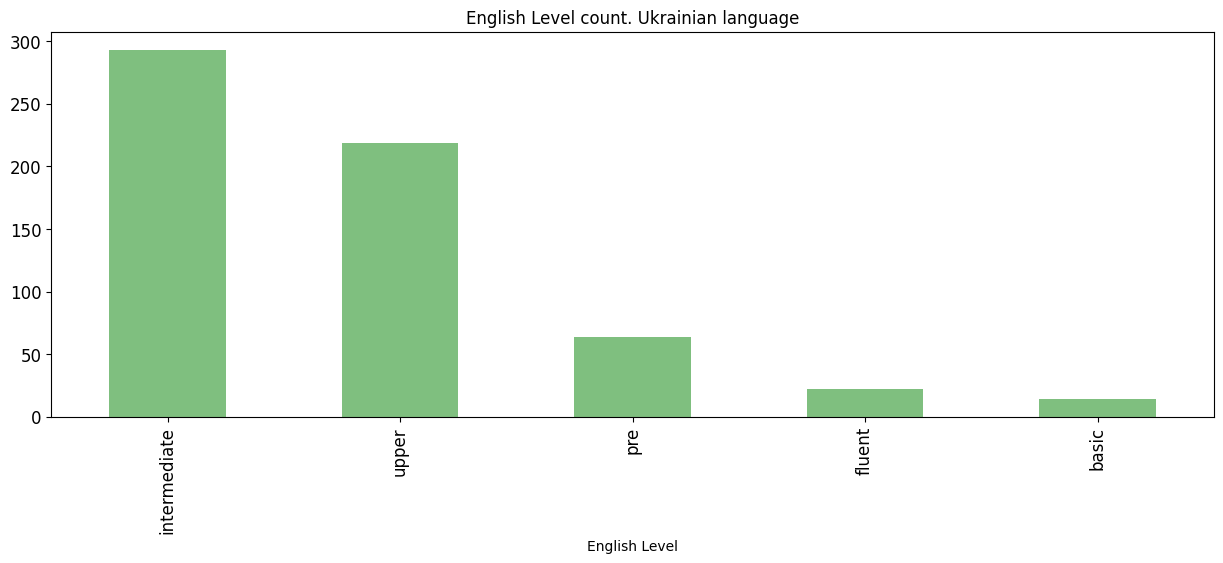

In [39]:
# English Level bar chart for Ukrainian language
df[df['Long Description_lang']=='uk']['English Level'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='English Level count. Ukrainian language',
                                        fontsize=12, color='green', alpha=0.5)

## Published
`date of publishing`

<Axes: title={'center': 'Year of publication count'}, xlabel='Published_year'>

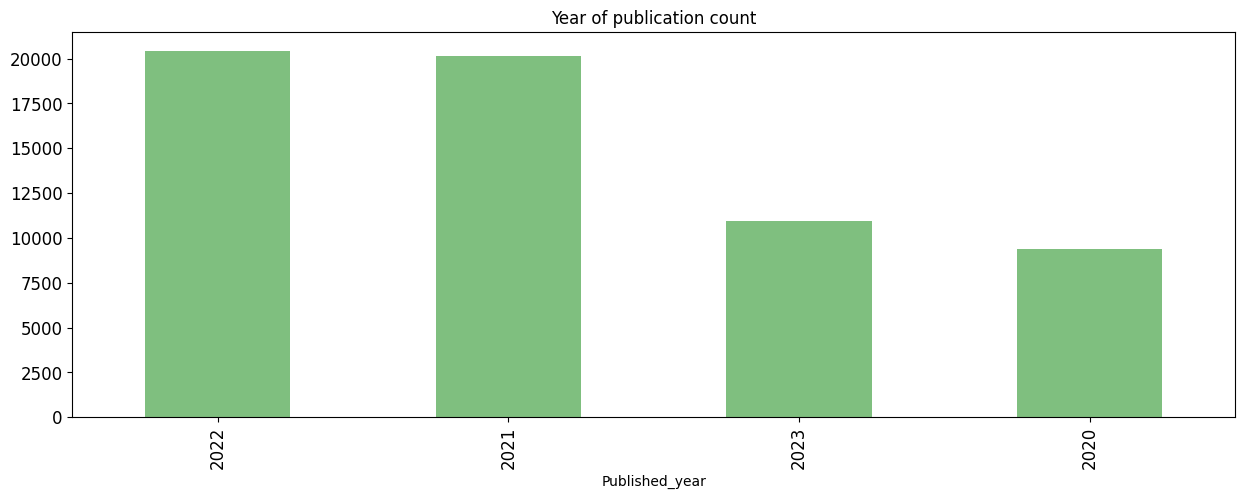

In [40]:
# year of publication bar chart
df['Published_year'] = df['Published'].apply(lambda x: int(re.findall(r'\d{4}', x)[0]))
df['Published_year'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='Year of publication count',
                                        fontsize=12, color='green', alpha=0.5)

Text(0.5, 1.0, 'Top 20 most popular positions per year')

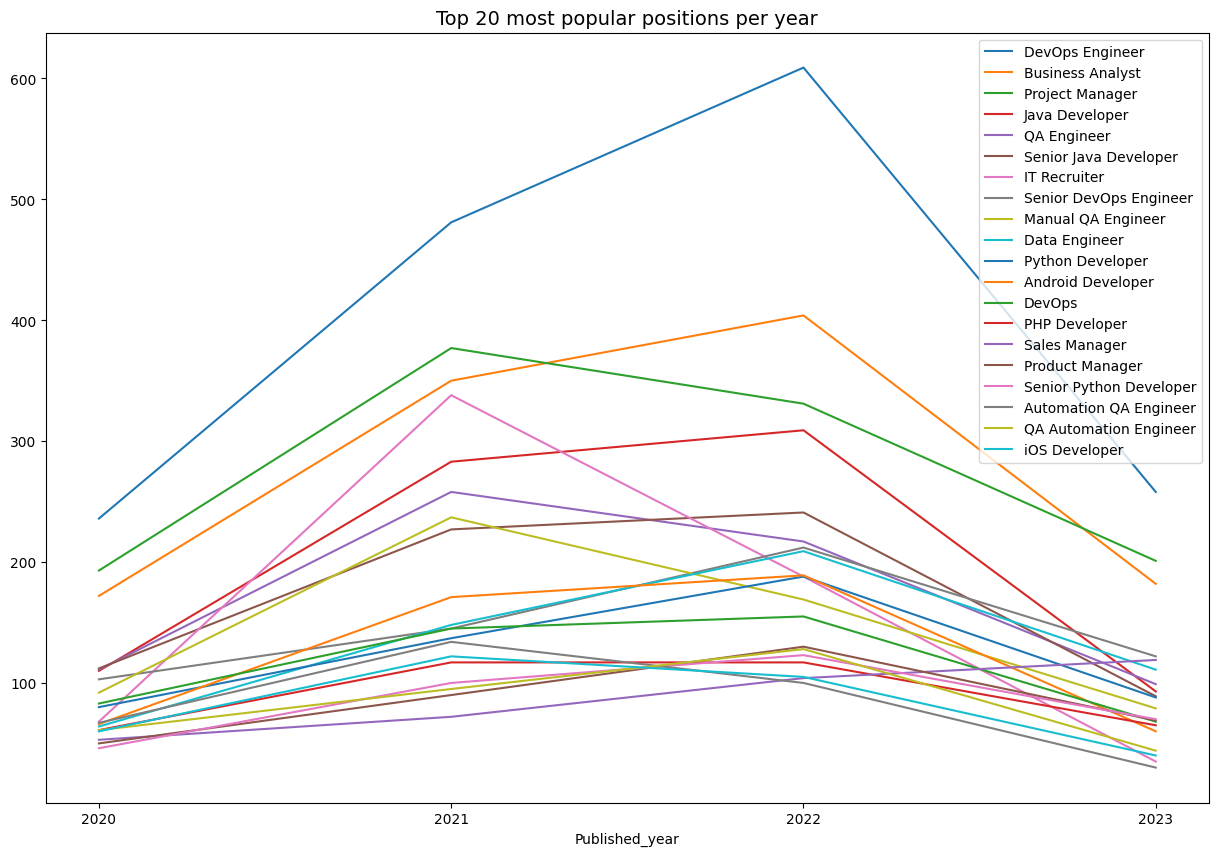

In [41]:
# line plot of top 20 most popular positions per year
plt.figure(figsize=(15,10))
for pos in df['Position'].value_counts()[:20].index:
    df[df['Position']==pos]['Published_year'].value_counts().sort_index().plot(kind='line', label=pos)
plt.legend()
plt.xticks([2020, 2021,2022,2023])
plt.title('Top 20 most popular positions per year', fontsize=14)


### Long Description_lang
`syntetic created column from Long Description column for language detection`

<Axes: title={'center': 'Long Description_lang column value counts'}, ylabel='count'>

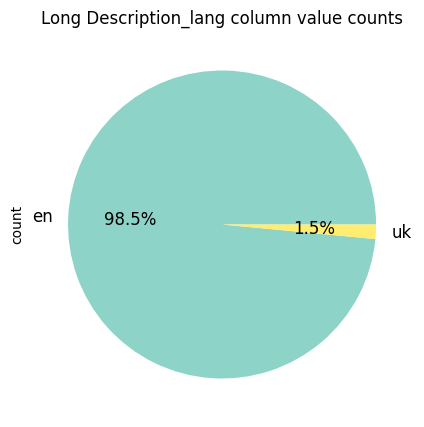

In [42]:
# Long Description_lang column value counts as a pie chart
df['Long Description_lang'].value_counts().plot(kind='pie', figsize=(5,5), title='Long Description_lang column value counts', fontsize=12, autopct='%1.1f%%', colormap='Set3')

### id column
`synthetic created column for identifcation each job`

## Morphological analysis of Job Descriptions

In [43]:
# detect percantage where we have feminitive in Ukrainian Long Descriptions

morph = pymorphy3.MorphAnalyzer(lang='uk')

def detect_feminitive(text):
    words = tokenize_uk.tokenize_uk.tokenize_words(text)
    verbs = [morph.parse(word)[0].word for word in words if morph.parse(word)[0].tag.POS == 'VERB']
    femn_verb_len = len([morph.parse(word)[0].tag.gender for word in verbs if morph.parse(word)[0].tag.gender == 'femn'])
    if femn_verb_len == 0 or len(verbs) == 0:
        return 0
    
    gender = femn_verb_len/len(verbs)
    return 1 if gender > 0.5 else 0

count = 0
ukr_cv = df[df['Long Description_lang'] == 'uk']['Long Description'].values
for cv_text in tqdm(ukr_cv):
    count+=detect_feminitive(cv_text)
print("Percentage of feminitive in Ukrainian CVs:", count/len(ukr_cv))

100%|██████████| 918/918 [00:08<00:00, 108.86it/s]

Percentage of feminitive in Ukrainian CVs: 0.0


## Protected groups detect by languages(other than gender)

In [44]:
def protected_groups_uk(values:list[str]):
    marital_count = 0
    military_count = 0
    religion_count = 0
    age_count = 0
    marital_detect_exp = []
    military_detect_exp = []
    religion_detect_exp = []
    age_detect_exp = []
    for val in values:
        if re.search(r'сімейний статус', val) or re.search(r'заміжн', val) or re.search(r'одружен', val):
            marital_count+=1
            marital_detect_exp.append(val)
        if re.search(r'військов', val) or re.search(r'військ', val):
            military_count+=1
            military_detect_exp.append(val)
        if re.search(r'релігія', val):
            religion_count+=1
            religion_detect_exp.append(val)
        if re.search(r'вік', val):
            age_count+=1
            age_detect_exp.append(val)

    print("Marital status count:", marital_count)
    print("Marital status:", marital_count/len(values))
    print("EXAMPLES:")
    for exp in marital_detect_exp[:5]:
        print(exp)
        print()
    print("\nMilitary status count:", military_count)
    print("Military status:", military_count/len(values))
    print("EXAMPLES:")
    for exp in military_detect_exp[:5]:
        print(exp)
        print()
    print("\nReligion status count:", religion_count)
    print("Religion status:", religion_count/len(values))
    print("EXAMPLES:")
    for exp in religion_detect_exp[:5]:
        print(exp)
        print()
    print("\nAge status count:", age_count)
    print("Age status:", age_count/len(values))
    print("EXAMPLES:")
    for exp in age_detect_exp[:5]:
        print(exp)
        print()
        
    
def protected_groups_en(values:list[str]):
    marital_count = 0
    military_count = 0
    religion_count = 0
    age_count = 0
    marital_detect_exp = []
    military_detect_exp = []
    religion_detect_exp = []
    age_detect_exp = []
    for val in values:
        if re.search(r'marital status', val) or re.search(r'married', val):
            marital_count+=1
            marital_detect_exp.append(val)
        if re.search(r'military', val):
            military_count+=1
            military_detect_exp.append(val)
        if re.search(r'religion', val):
            religion_count+=1
            religion_detect_exp.append(val)
        if re.search(r'candidate age', val.lower()):
            age_count+=1
            age_detect_exp.append(val)

    print("Marital status count:", marital_count)
    print("Marital status:", marital_count/len(values))
    print("EXAMPLES:")
    for exp in marital_detect_exp[:5]:
        print(exp)
        print()
    print("\nMilitary status count:", military_count)
    print("Military status:", military_count/len(values))
    print("EXAMPLES:")
    for exp in military_detect_exp[:5]:
        print(exp)
        print()
    print("\nReligion status count:", religion_count)
    print("Religion status:", religion_count/len(values))
    print("EXAMPLES:")
    for exp in religion_detect_exp[:5]:
        print(exp)
        print()
    print("\nAge status count:", age_count)
    print("Age status:", age_count/len(values))
    print("EXAMPLES:")
    for exp in age_detect_exp[:5]:
        print(exp)
        print()

print("Ukrainian Long Description:")
protected_groups_uk(df[df['Long Description_lang'] == 'uk']['Long Description'].values)
print("\nEnglish  Long Description::")
protected_groups_en(df[df['Long Description_lang'] == 'en']['Long Description'].values)

Ukrainian Long Description:
Marital status count: 2
Marital status: 0.002178649237472767
EXAMPLES:
**Обов’язки: **
Розробляти веб-сайти WordPress з нуля 
Розробляти веб-сайти WordPress на основі тем 
Надавати обґрунтовані та точні оцінки часу для виконання завдань та дотримуватись зазначених термінів 
Брати участь у Code Review
Підтримувати існуючі веб-сайти WordPress 
Брати участь в оцінці і плануванні 

**Вимоги: **
1+ рік досвіду роботи з WordPress
Знання HTML і CSS 
Знання JavaScript / jQuery 
Знання PHP 
Досвід роботи з ACF 
Досвід роботи з Photoshop / Figma / AdobeXD 
Розуміння робочого процесу Git 

**Що ми пропонуємо?**
Команда має для нас велике значення, тому ми цінуємо її та надаємо можливість кожному ділитися своїм баченням, втілювати власні ідеї, зростати у професійному середовищі, зберігаючи баланс між роботою та особистим життям.

Приєднавшись до Viseven, ви отримаєте:
Конкурентну винагороду та регулярний перегляд заробітної плати
Професійне та кар’єрне зростання
Оплачув

After simple analyses of detecting protected groups in Job Description, we can tell that there are no protected groups in the job descriptions, all findings are false positives.

## Manual check of data sample(10 samples English language)

In [45]:
for text in df[df['Long Description_lang']=='en'].sample(10)['Long Description']:
    print(text)
    print('-'*100, '\n\n')

**Requirements:**
• 0,5+ years of experience in recruiting for technical vacancies;
• Proven work experience as a Talent Sourcer or similar role in IT sphere;
• Hands-on experience with sourcing techniques (e.g. recruiting on social platforms and crafting Boolean search strings);
• Familiarity with HR databases, Applicant Tracking Systems (ATSs) and  Candidate Management Systems (CMSs);
• Solid verbal and written communication skills;
• Excellent negotiation skills;
• Ability to positively present our company and open roles to potential candidates;
• Effective time-management abilities;

**Responsibilities:**
• Interact with potential candidates on social media and professional networks (e.g. LinkedIn, Github, Djinni)
• Craft and send recruiting emails
• Coordinate with hiring managers to determine position requirements
• Manage candidate interview schedule with HR
• Identify qualified candidate profiles using various sourcing techniques (e.g. Boolean search)
• Develop talent pipelines

## Manual check of data sample(10 samples Ukrainian language)

In [46]:
for text in df[df['Long Description_lang']=='uk'].sample(10)['Long Description']:
    print(text)
    print('-'*100, '\n\n')

**Цінності компанії:** чесність та відкритість, комунікація, професіоналізм та новаторство. 
Ми намагаємось робити все, щоб ці принципи були не просто словами, а відчувались в роботі кожен день.

Шукаємо в команду старанного та відповідального **Junior QA Engineer**! Готові навчати та допомагати. Якщо ти мрієш про цікавий досвід роботи та нові знання на позиції QA Engineer - тоді ми чекаємо саме на тебе!


**Розповідаю тобі, чим ти будеш займатись:**
- Тестуванням нового та поточного функціоналу;
- Веденням тестової документації ( написання тест-кейсів та чек-листів);
- Ідентифікацією помилок та внесенням їх в трекінгову систему;
- Регресійним тестуванням;
- Будеш приймати участь в життєвому циклі продукту;
- Спілкуватись з РМ-ами та розробниками стосовно змін в продукті.


**Ми розуміємо, що шукаємо новачка в цій сфері, але все ж буде плюсом, якщо ти володієш такими знаннями та досвідом:**
- Досвідом тестування клієнт-сервісних додатків / досвідом тестування API;
- Вмінням описувати п